用路网和行政区划数据生成地块矢量
提供的基础数据是：

GIS文件：
1.深圳行政区划
2.深圳路网

## 读取数据

In [3]:
import warnings

warnings.filterwarnings('ignore')

<AxesSubplot:>

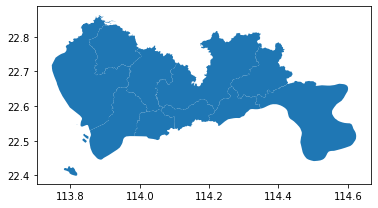

In [4]:
#导入必要的包
import pandas as pd
import numpy as np

#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas包
import geopandas

#shapely包
from shapely.geometry import Point,Polygon,shape

#读取shapefile文件
shp = r'shapefile/sz.shp'
sz = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#绘制看看长什么样
sz.plot()

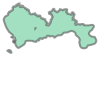

In [5]:
#将深圳合并为一个单一的shapely geometry
sz = sz.unary_union
sz

<AxesSubplot:>

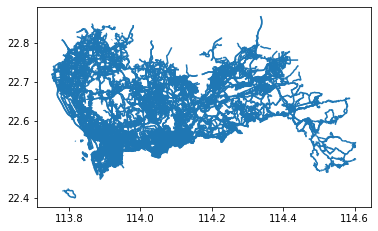

In [6]:
#路网
shp = r'shapefile/shenzhen_osmroad.shp'
road = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#绘制看看长什么样
road.plot()

## 开始
首先我们将路网的线和行政区划的面的边界组合到一起

<AxesSubplot:>

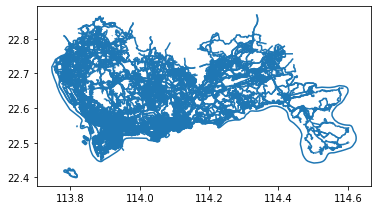

In [7]:
lines = list(road['geometry'])+list(sz.boundary)
geopandas.GeoDataFrame({'geometry':lines}).plot()

用上面的线段构成面

In [8]:
import shapely
#第一个操作：把相邻的线合成到一起，即A的起点和B终点在同一个位置，那么把AB合成一起（如果不这样做，后面得到的结果可能会在AB端点处打断，但AB端点不一定是交点）
merged_lines = shapely.ops.linemerge(lines)
#第二个操作：合并为整体，但是实际上是线段的组合，会在交点处打断
border_lines = shapely.ops.unary_union(merged_lines)
#上面两个操作连起来实现的功能就是在交点处打断线
#第三个操作：生成线段所组成的面
decomposition = shapely.ops.polygonize_full(border_lines)

In [9]:
# decomposition这个东西实际上生成的是四个东西,第一个东西是切割出来的面
decomposition

(<shapely.geometry.collection.GeometryCollection at 0x1ca05747850>,
 <shapely.geometry.collection.GeometryCollection at 0x1ca05747940>)

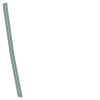

In [10]:
decomposition[0][0]


把面搞成一个geodataframe

In [11]:
area = geopandas.GeoDataFrame({'geometry':list(decomposition[0])})

这里我们遇到一个问题，就是道路是有宽度的，但是反映在osm上面就是一条线，没有宽度。
而一条快速路又可能会由几条平行的线组成，这样切分出来的快速路也会形成面
但是，我们想要的是，路围成的地块的面
这里我采用的方法是，反向buffer一个道路的宽度，这样切分出来的快速路的面因为是条状的，buffer一下就没了；地块则会被保留
试一下，反向buffer0.00015

In [12]:
area1 = area.buffer(-0.00015)
#经纬度的1°大约等于111.111km，也就是说
#这里设定的0.00015大约是
#0.00015*1000*111.111 = 16.66665m

#接下来把buffer一下就没了的面删除
area1 = area1[-area1.is_empty]

#生成一个新的gdf
area1 = geopandas.GeoDataFrame({'geometry':area1})

In [21]:
area1

,geometry
2,"POLYGON ((113.76060 22.71864, 113.76060 22.718..."
3,"POLYGON ((113.76055 22.71920, 113.76066 22.719..."
6,"POLYGON ((113.76157 22.71287, 113.76173 22.712..."
7,"POLYGON ((113.76147 22.71337, 113.76149 22.713..."
8,"POLYGON ((113.76210 22.71011, 113.76223 22.710..."
...,...
34227,"POLYGON ((114.30917 22.60071, 114.30916 22.600..."
34230,"POLYGON ((114.37005 22.73948, 114.37100 22.739..."
34231,"POLYGON ((114.41155 22.69967, 114.41151 22.699..."
34232,"POLYGON ((114.45369 22.57692, 114.45367 22.576..."


<AxesSubplot:>

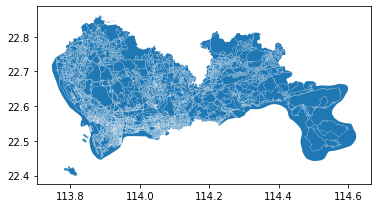

In [22]:
area1.plot()

<AxesSubplot:>

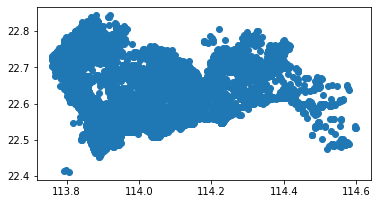

In [14]:
#提取每个地块的中心点
#生成一个新的gdf叫areacentroid
#存储这些地块的中心点
areacentroid = area1.copy()
areacentroid['geometry'] = area1.centroid
areacentroid.plot()

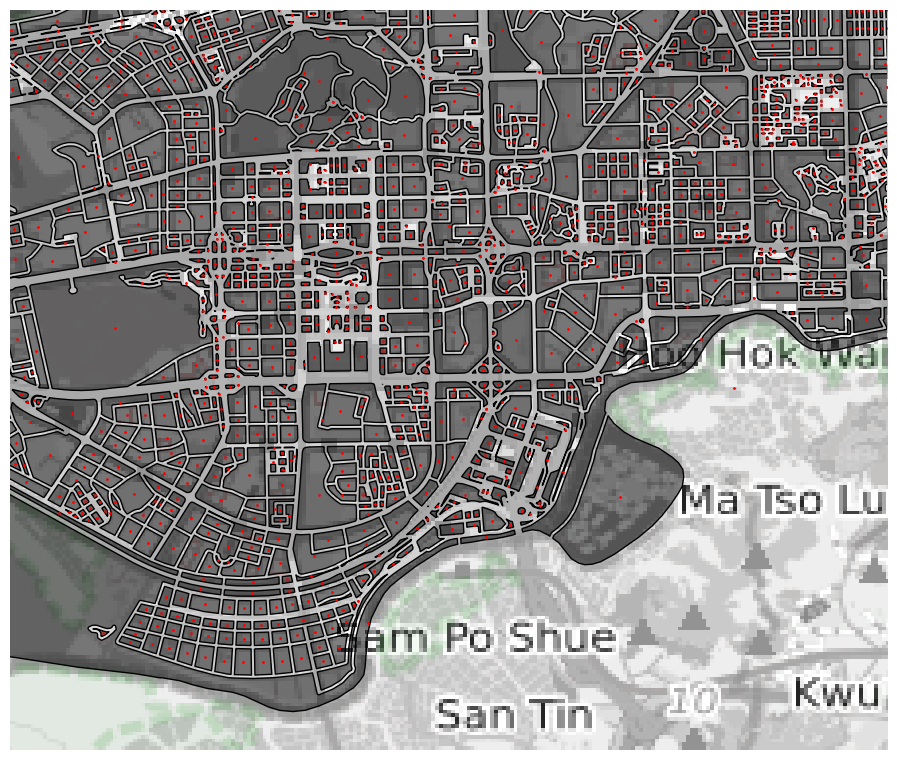

In [29]:
#放大看看
lat1sh = 22.499;
lat2sh = 22.564;
lon1sh = 114.026;
lon2sh = 114.103;
bounds = [lon1sh,lat1sh,lon2sh,lat2sh]

import matplotlib as mpl
import matplotlib.pyplot as plt
import plot_map
import seaborn as sns
fig     = plt.figure(1,(10,10),dpi = 100)      
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))

#背景
#plot_map.plot_map(plt,bounds,zoom = 14,style = 4) zoom=14看不到背景图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#绘制地块
area1.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.5))
#绘制地块中心点
areacentroid.plot(ax = ax,markersize = 1,color = 'red')


plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

plt.show()